## A DNN Regression

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

for m in mpl, np, pd, sns, tf, keras:
    print(m.__name__, m.__version__)

matplotlib 3.3.2
numpy 1.19.2
pandas 1.1.3
seaborn 0.11.0
tensorflow 2.3.1
tensorflow.keras 2.4.0


### Step 1. load te data

In [2]:
# load raw dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
              'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

raw_dataset.shape

(398, 8)

### Step 2. clean the data

In [3]:
# drop NaN unknown data
dataset = raw_dataset.copy()
dataset = dataset.dropna()

# one-hot encoding
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

dataset.shape

(392, 10)

### Step 3. split the data into train and test

In [4]:
# split data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_features.shape, train_labels.shape

((314, 9), (314,))

### Step 4. Normalization

In [5]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

normalizer.mean.numpy()

array([5.4777069e+00, 1.9531847e+02, 1.0486943e+02, 2.9902517e+03,
       1.5559236e+01, 7.5898087e+01, 1.7834395e-01, 1.9745223e-01,
       6.2420380e-01], dtype=float32)

### DNN regression

These models will contains a few more layers than the linear model:
* The normalization layer
* Two hidden, nonlinear, Dense layers using the relu nonlinearity.
* A linear single-output layer.

In [6]:
# build and compile the model

def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                 optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

### One variable

In [7]:
# input
horsepower = np.array(train_features['Horsepower'])

# normalization layer
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

# build and compile model
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

# summary
dnn_horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [8]:
# from tqdm import tnrange, notebook
# from time import sleep

# for i in notebook.tqdm(range(4), desc='1st loop'):
#     for j in notebook.tqdm(range(100), desc='2nd loop'):
#         sleep(0.01)

In [9]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

CPU times: user 3.29 s, sys: 407 ms, total: 3.69 s
Wall time: 2.91 s


In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

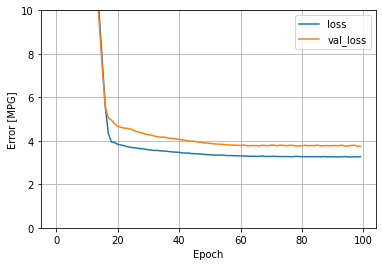

In [11]:
plot_loss(history)

In [12]:
test_results = {}
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels, verbose=0)

In [13]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

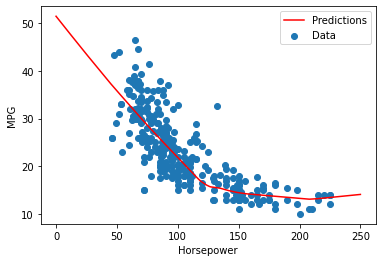

In [14]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='r', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()
    
plot_horsepower(x, y)

### Full model

In [15]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [16]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

CPU times: user 3.11 s, sys: 429 ms, total: 3.53 s
Wall time: 2.69 s


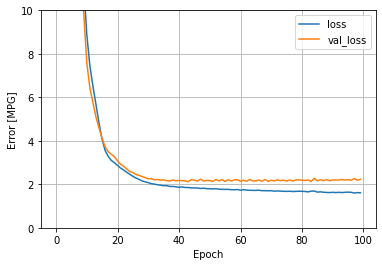

In [17]:
plot_loss(history)

In [18]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

### Make predictions

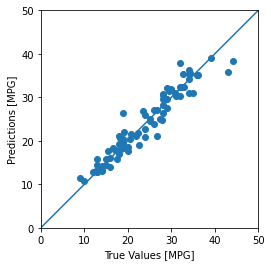

In [19]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

### Error distribution

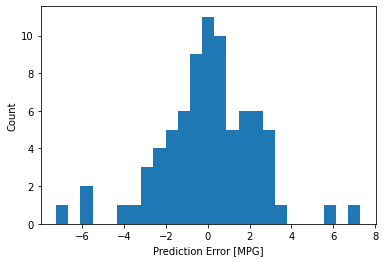

In [20]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

### Model save

In [21]:
dnn_model.save('dnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dnn_model/assets


In [22]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0
)

### Performance

In [23]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_horsepower_model,2.960239
dnn_model,1.708589
reloaded,1.708589
